Text(value='Jakarta, Bandung, Surabaya', description='Kota:', placeholder='Pisahkan dengan koma')

Button(description='Ambil Data', style=ButtonStyle())

,Kota,Suhu (°C),Cuaca,Kelembaban (%),Kecepatan Angin (m/s),Icon
0,Sago,12.06,Moderate rain,98,1.41,http://openweathermap.org/img/wn/10d@2x.png
1,Salido,24.30,Overcast clouds,92,1.76,http://openweathermap.org/img/wn/04n@2x.png
2,Painan,25.43,Overcast clouds,88,1.72,http://openweathermap.org/img/wn/04n@2x.png


Dropdown(description='Detail:', options=('Sago', 'Salido', 'Painan'), value='Sago')

,Parameter,Nilai
0,Kota,Salido
1,Suhu (°C),24.300000
2,Cuaca,Overcast clouds
3,Kelembaban (%),92
4,Kecepatan Angin (m/s),1.760000
5,Icon,http://openweathermap.org/img/wn/04n@2x.png


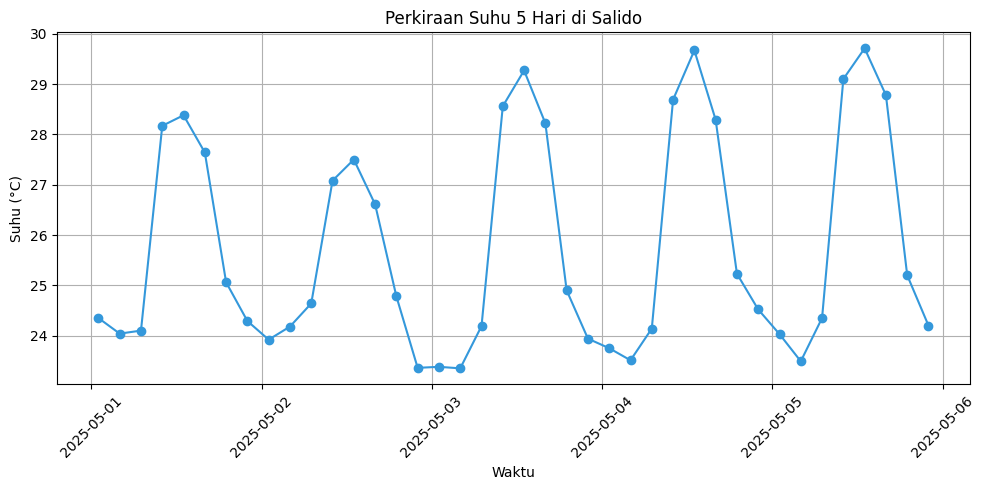

,Parameter,Nilai
0,Kota,Sago
1,Suhu (°C),12.060000
2,Cuaca,Moderate rain
3,Kelembaban (%),98
4,Kecepatan Angin (m/s),1.410000
5,Icon,http://openweathermap.org/img/wn/10d@2x.png


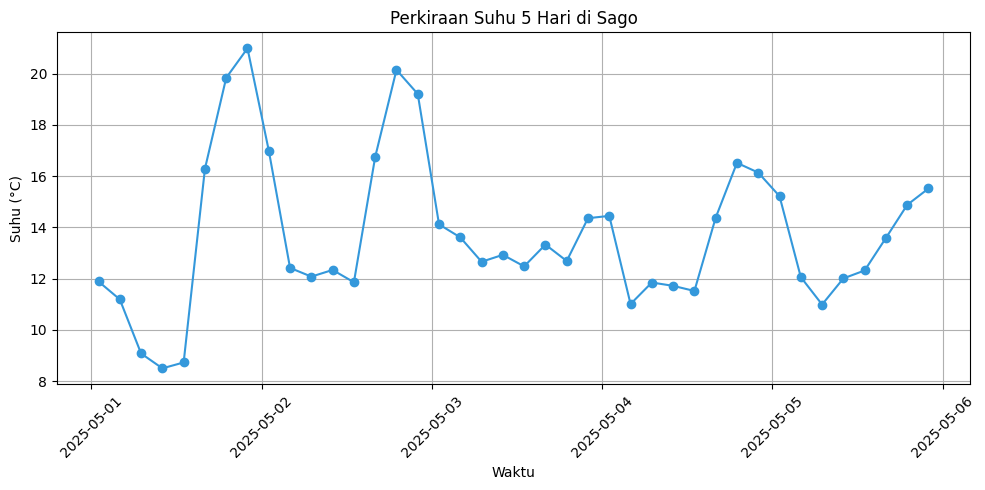

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import widgets, interact
from IPython.display import display, Image
from datetime import datetime

# API Key
api_key = 'f6a79db0fba22353d1625b676200f157'

# Ambil data cuaca realtime
def get_weather(city_name, api_key):
    url = "http://api.openweathermap.org/data/2.5/weather"
    params = {'q': city_name, 'appid': api_key, 'units': 'metric'}
    response = requests.get(url, params=params)
    data = response.json()
    
    if response.status_code == 200:
        icon_code = data['weather'][0]['icon']
        weather_info = {
            'Kota': data['name'],
            'Suhu (°C)': data['main']['temp'],
            'Cuaca': data['weather'][0]['description'].capitalize(),
            'Kelembaban (%)': data['main']['humidity'],
            'Kecepatan Angin (m/s)': data['wind']['speed'],
            'Icon': f"http://openweathermap.org/img/wn/{icon_code}@2x.png"
        }
        return weather_info
    else:
        return None

# Forecast 5 hari tiap 3 jam
def get_forecast(city_name, api_key):
    url = "http://api.openweathermap.org/data/2.5/forecast"
    params = {'q': city_name, 'appid': api_key, 'units': 'metric'}
    response = requests.get(url, params=params)
    data = response.json()
    
    if response.status_code == 200:
        forecast_list = []
        for item in data['list']:
            forecast_list.append({
                'Waktu': datetime.fromtimestamp(item['dt']),
                'Suhu (°C)': item['main']['temp']
            })
        df = pd.DataFrame(forecast_list)
        return df
    else:
        return None

# Tampilkan tabel dan icon
def display_weather(data):
    df = pd.DataFrame(data.items(), columns=['Parameter', 'Nilai'])
    display(df.style.set_properties(**{'text-align': 'left'}))
    display(Image(url=data['Icon']))

# Plot grafik suhu forecast
def plot_forecast(forecast_df, city):
    plt.figure(figsize=(10,5))
    plt.plot(forecast_df['Waktu'], forecast_df['Suhu (°C)'], marker='o', color='#3498db')
    plt.title(f'Perkiraan Suhu 5 Hari di {city}')
    plt.xlabel('Waktu')
    plt.ylabel('Suhu (°C)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Multi kota dengan dropdown interaktif
def interactive_weather():
    cities_input = widgets.Text(
        value='Jakarta, Bandung, Surabaya',
        description='Kota:',
        placeholder='Pisahkan dengan koma'
    )
    display(cities_input)
    
    button = widgets.Button(description="Ambil Data")
    display(button)
    
    def on_button_clicked(b):
        cities = [city.strip() for city in cities_input.value.split(',')]
        weather_data = []
        for city in cities:
            data = get_weather(city, api_key)
            if data:
                weather_data.append(data)
            else:
                print(f"Data untuk {city} tidak ditemukan.")
        
        df = pd.DataFrame(weather_data)
        display(df)

        # Simpan ke Excel & CSV
        df.to_excel('cuaca_kota.xlsx', index=False)
        df.to_csv('cuaca_kota.csv', index=False)
        print("Data berhasil disimpan ke cuaca_kota.xlsx dan cuaca_kota.csv")

        # Dropdown untuk pilih kota dan tampilkan detail
        dropdown = widgets.Dropdown(options=cities, description='Detail:')
        display(dropdown)

        def on_dropdown_change(change):
            if change['type'] == 'change' and change['name'] == 'value':
                selected_city = change['new']
                data = get_weather(selected_city, api_key)
                forecast_df = get_forecast(selected_city, api_key)
                if data:
                    display_weather(data)
                    if forecast_df is not None:
                        plot_forecast(forecast_df, selected_city)
                    else:
                        print("Data forecast tidak tersedia.")
        dropdown.observe(on_dropdown_change)

    button.on_click(on_button_clicked)

# Jalankan aplikasi interaktif
interactive_weather()
